In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [2]:
splice_df = pd.read_csv('splice_sites_full_centered_balanced_correct_V3.csv')
splice_df.head()

,id,coord,kind,transcript,strand,chrom,start,end,sequence,win_start,win_end,is_truncated,motif_len,motif
0,NC_050096.1_35318_donor,35318,0,XM_020544715.3,+,NC_050096.1,35319,35320,GGGCCCGGCTGGGCCTCAGCGGGGTCGTCGAGATGGAGATGGGGAG...,35118,35520,False,2,GT
1,NC_050096.1_34607_acceptor,34607,1,XM_020544715.3,+,NC_050096.1,34605,34606,TCCGGTGATTAATTTGTCCTTATACCTTTACAACAAAAATTCACTA...,34404,34806,False,2,TG
2,NC_050096.1_36174_donor,36174,0,XM_020544715.3,+,NC_050096.1,36175,36176,ATAATATGTTCATTATATCACAACACTCTTTTCTTATGGAGTCGTG...,35974,36376,False,2,GT
3,NC_050096.1_36037_acceptor,36037,1,XM_020544715.3,+,NC_050096.1,36035,36036,GCACAAAACTAACTAAAGGAATCATTCTGATAGATAACACTATAAA...,35834,36236,False,2,AG
4,NC_050096.1_36504_donor,36504,0,XM_020544715.3,+,NC_050096.1,36505,36506,TGTCATTTCCTTACCTCATTGAATCATTTCCGATGCTTCTTCTCTG...,36304,36706,False,2,GT


In [3]:
# Split data with stratification
train_df, temp_df = train_test_split(splice_df, test_size=0.3, stratify=splice_df['kind'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['kind'], random_state=42)

## Full Pipeline

In [4]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.4.0+cu121
CUDA available: True
CUDA version: 12.1


In [14]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoConfig
from mamba_ssm import Mamba
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [23]:
# Cell 2: Dataset Class (Modified)
class DNASequenceAndEmbeddingDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, bert_model, device, max_length=512):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.device = device
        self.max_length = max_length
        
        # Nucleotide to index mapping
        self.nuc_to_idx = {
            'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4,
            'P': 5  # P for padding
        }
        
        # Pre-compute embeddings and encodings
        self.embeddings = []
        self.seq_encodings = []
        
        with torch.no_grad():
            for seq in tqdm(sequences, desc="Computing embeddings"):
                # Get BERT embeddings
                inputs = self.tokenizer(
                    seq,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt"
                )
                inputs = {k: v.to(device) for k, v in inputs.items()}
                outputs = self.bert_model(**inputs)
                # DNABERT-2 returns a tuple where the first element is hidden states
                embeddings = outputs[0].cpu()  # Changed this line
                self.embeddings.append(embeddings)
                
                # Create sequence encoding
                seq_encoding = torch.tensor([
                    self.nuc_to_idx.get(nuc, self.nuc_to_idx['N']) 
                    for nuc in (seq[:max_length] + 'P' * max(0, max_length - len(seq)))
                ], dtype=torch.long)
                self.seq_encodings.append(seq_encoding)
        
        # Convert labels to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx].squeeze(0),
            'sequence': self.seq_encodings[idx],
            'label': self.labels[idx]
        }

In [24]:
# Cell 3: Model Architecture
class DNABertMambaWithSequenceClassifier(nn.Module):
    def __init__(self, d_model=768, n_classes=3, d_state=16, d_conv=4, expand=2):
        super().__init__()
        
        # Nucleotide embedding
        self.nuc_embedding = nn.Embedding(6, 32)  # 6 tokens (ACGTN + PAD), 32 dimensions
        
        # Combine sequence and BERT embeddings
        self.combine_layer = nn.Sequential(
            nn.Linear(d_model + 32, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU()
        )
        
        # Mamba configuration
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
            use_fast_path=True  # Added for PyTorch 1.12.0 compatibility
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(0.1),
            nn.Linear(d_model, n_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, embeddings, sequence, labels=None):
        # Get nucleotide embeddings
        seq_embeddings = self.nuc_embedding(sequence)
        
        # Combine BERT embeddings with sequence embeddings
        combined = torch.cat([embeddings, seq_embeddings], dim=-1)
        x = self.combine_layer(combined)
        
        # Pass through Mamba
        x = self.mamba(x)
        
        # Global average pooling
        x = x.mean(dim=1)
        
        # Classification
        logits = self.classifier(x)
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, logits
        return None, logits

In [25]:
# Cell 4: Model Initialization (Modified)
def prepare_model_and_data(train_df, test_df, sample_size=5000):
    # Sample the data (keeping the stratified sampling)
    train_sample_size = min(sample_size, len(train_df))
    test_sample_size = min(sample_size//5, len(test_df))
    
    train_df_sample = train_df.groupby('kind', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), train_sample_size // 3))
    ).reset_index(drop=True)
    
    test_df_sample = test_df.groupby('kind', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), test_sample_size // 3))
    ).reset_index(drop=True)
    
    # Initialize BERT
    model_name = "zhihan1996/DNABERT-2-117M"
    
    # Create config first
    config = AutoConfig.from_pretrained(
        model_name,
        trust_remote_code=True
    )
    
    # Modify config to use standard attention
    config.attention_probs_dropout_prob = 0.1
    config.hidden_dropout_prob = 0.1
    
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    
    # Initialize BERT model
    bert_model = AutoModel.from_pretrained(
        model_name,
        config=config,
        trust_remote_code=True
    )
    
    # Force model to float32
    bert_model = bert_model.float()
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Freeze BERT and move to device
    for param in bert_model.parameters():
        param.requires_grad = False
    bert_model = bert_model.to(device)
    
    # Create datasets
    train_dataset = DNASequenceAndEmbeddingDataset(
        sequences=train_df_sample['sequence'].tolist(),
        labels=train_df_sample['kind'].tolist(),
        tokenizer=tokenizer,
        bert_model=bert_model,
        device=device
    )
    
    test_dataset = DNASequenceAndEmbeddingDataset(
        sequences=test_df_sample['sequence'].tolist(),
        labels=test_df_sample['kind'].tolist(),
        tokenizer=tokenizer,
        bert_model=bert_model,
        device=device
    )
    
    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    # Initialize model
    model = DNABertMambaWithSequenceClassifier(
        d_model=768,
        n_classes=3,
        d_state=16,
        d_conv=4,
        expand=2
    )
    model = model.to(device)
    
    return model, train_dataloader, test_dataloader, device

In [28]:
# Cell 5: Training Function (Modified)
def train_model(model, train_dataloader, val_dataloader, device, 
                num_epochs=10, patience=3, learning_rate=1e-4):
    
    # Initialize optimizer and tracking variables
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Initialize tracking lists
    history = {
        'epoch': [], 'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [], 'learning_rate': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            embeddings = batch['embeddings'].to(device)
            sequence = batch['sequence'].to(device)
            labels = batch['label'].to(device)  # Changed from 'labels' to 'label'
            
            optimizer.zero_grad()
            loss, logits = model(embeddings, sequence, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_total
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                embeddings = batch['embeddings'].to(device)
                sequence = batch['sequence'].to(device)
                labels = batch['label'].to(device)  # Changed from 'labels' to 'label'
                
                loss, logits = model(embeddings, sequence, labels)
                total_val_loss += loss.item()
                
                # Calculate accuracy
                predictions = torch.argmax(logits, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)
        history['learning_rate'].append(current_lr)
        
        # Print metrics
        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        print(f'Learning Rate: {current_lr}')
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Convert history to DataFrame
    history_df = pd.DataFrame(history)
    return history_df

In [29]:
# Cell 6: Run the Pipeline
# Initialize model and data
model, train_dataloader, test_dataloader, device = prepare_model_and_data(
    train_df=train_df,
    test_df=test_df,
    sample_size=5000
)

# Train the model
history_df = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    device=device,
    num_epochs=10,
    patience=3,
    learning_rate=1e-4
)

/tmp/ipykernel_977352/2408026006.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_sample = train_df.groupby('kind', group_keys=False).apply(
/tmp/ipykernel_977352/2408026006.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df_sample = test_df.groupby('kind', group_keys=False).apply(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and

Using device: cuda


Computing embeddings:   0%|          | 0/4998 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/999 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 1/10:   0%|          | 0/157 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/10:
Train Loss: 1.1209, Train Acc: 0.3846
Val Loss: 0.8732, Val Acc: 0.5425
Learning Rate: 0.0001


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 2/10:   0%|          | 0/157 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/10:
Train Loss: 0.8747, Train Acc: 0.5458
Val Loss: 0.8091, Val Acc: 0.5516
Learning Rate: 0.0001


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 3/10:   0%|          | 0/157 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/10:
Train Loss: 0.8484, Train Acc: 0.5638
Val Loss: 0.7962, Val Acc: 0.5596
Learning Rate: 0.0001


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 4/10:   0%|          | 0/157 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/10:
Train Loss: 0.7606, Train Acc: 0.5872
Val Loss: 1.0994, Val Acc: 0.4985
Learning Rate: 0.0001


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 5/10:   0%|          | 0/157 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/10:
Train Loss: 0.7191, Train Acc: 0.6218
Val Loss: 0.9579, Val Acc: 0.5265
Learning Rate: 0.0001


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 6/10:   0%|          | 0/157 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 6/10:
Train Loss: 0.5550, Train Acc: 0.7283
Val Loss: 0.9776, Val Acc: 0.5455
Learning Rate: 1e-05
Early stopping triggered after epoch 6


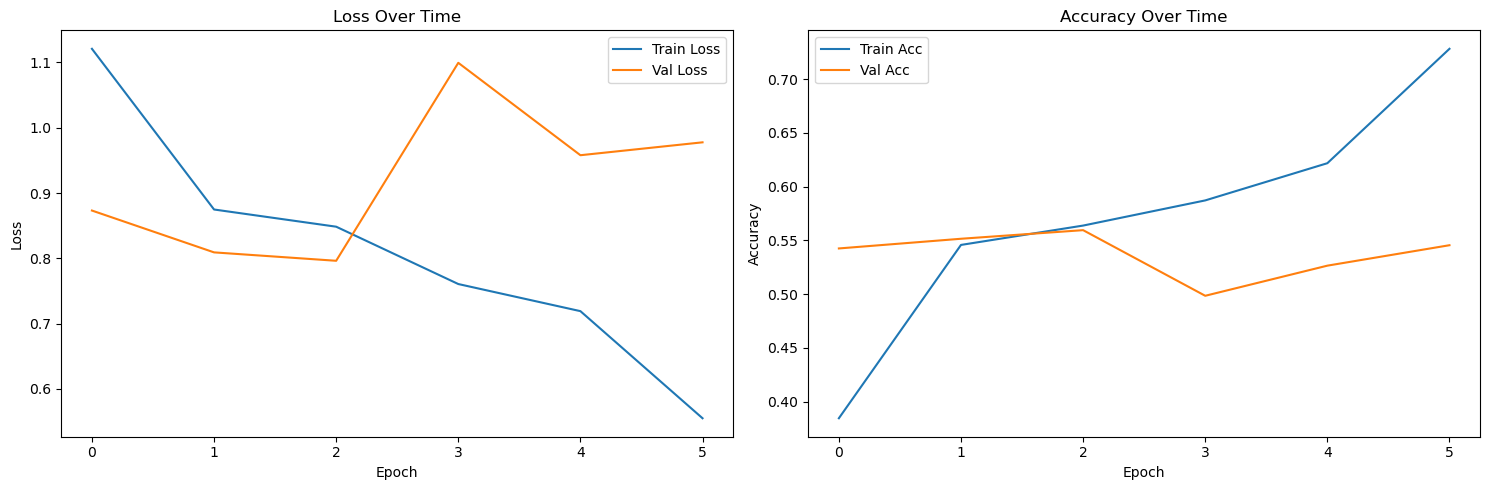

In [30]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['train_acc'], label='Train Acc')
plt.plot(history_df['val_acc'], label='Val Acc')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()